In [2]:
import numpy as np
from scipy.stats import norm, beta, ttest_ind
import matplotlib.pyplot as plt
##Setting the number of experiments
numberOfExperimentsToRun = 10000 
rangeOfMeans = (-100.0, 100.0)
# Approximately how many of the experiments will have a control that is the same as the treatment
# It's approximate because we use a random number generator to determine if any individual experiment should not be different
# (the remainder will be evenly split be better or worse)
percentNoDifference = 0.5
# How many units (or users) will be in each sample
unitsPerTreatment = 10000

In [3]:
class Experiment:
    def __init__(self, controlMean, controlStandardDeviation, treatmentMean, treatmentStandardDeviation, truth):
        self.controlMean = controlMean
        self.controlStandardDeviation = controlStandardDeviation
        self.treatmentMean = treatmentMean
        self.treatmentStandardDeviation = treatmentStandardDeviation
        self.truth = truth

def runAnExperiment(e:Experiment):

        # Generate samples from the population distributions for each group (control and treatment)
        controlSample = np.random.normal(e.controlMean, e.controlStandardDeviation, unitsPerTreatment)
        treatmentSample = np.random.normal(e.treatmentMean, e.treatmentStandardDeviation, unitsPerTreatment)

        # Calculate p-value using a two-sided t-test (we don't know which group is better) 
        pValue = ttest_ind(controlSample, treatmentSample).pvalue

        # Calculate the standard error of the mean for each sample (standard deviation / sqrt(sample size)) 
        controlSamplingStandardDeviation = np.std(controlSample) / np.sqrt(unitsPerTreatment)
        treatmentSamplingStandardDeviation = np.std(treatmentSample) / np.sqrt(unitsPerTreatment)

        # Create sampling distributions for each sample (mean +/- standard error of the mean) 
        controlSamplingDistribution = norm(np.mean(controlSample), controlSamplingStandardDeviation)
        treatmentSamplingDistribution = norm(np.mean(treatmentSample), treatmentSamplingStandardDeviation)

        # Monte Carlo simulation for number of times control wins over treatment 
        numberOfSimulations = 10000 

        # Generate samples from the sampling distributions for each group (control and treatment) 
        
        

         # Compare each pair of samples to see which one is greater and count how many times each group wins 
         # If it's a tie then flip a coin to decide who wins that round 
        
         # Initialize counters to 0 
        controlWinsCounter = 0 
        treatmentWinsCounter = 0

        for i in range(numberOfSimulations):
            controlSample = controlSamplingDistribution.rvs()
            treatmentSample = treatmentSamplingDistribution.rvs()

            if controlSample > treatmentSample:
                controlWinsCounter += 1
            elif controlSample == treatmentSample:
                if np.random.random() > 0.5:
                    controlWinsCounter += 1
                else:
                    treatmentWinsCounter += 1
            else:
                treatmentWinsCounter += 1

         # Convert number of wins to probability of winning
        pWinControl = (float(controlWinsCounter) / float(numberOfSimulations)) * 100.0
        pWinTreatment = (float(treatmentWinsCounter) / float(numberOfSimulations)) * 100.0

         # We know the true population mean, was the direction of the samples correct?  

         # We want to know this to see if our p-value is in the right direction.  

        sampleAgreesWithTruth = (
                e.controlMean > e.treatmentMean and np.mean(controlSample) > np.mean(treatmentSample) or
                e.controlMean < e.treatmentMean and np.mean(controlSample) < np.mean(treatmentSample)
        )

        return pValue <= 0.05, pWinTreatment > 50, sampleAgreesWithTruth



In [4]:
# the distribution of effect sizes
beta = beta(1, 20)

visualizeBeta = [beta.rvs() + 0.001 for i in range(10000)]
visualizeBeta



[0.028299654739517285,
 0.0034138211286754623,
 0.009712485550212212,
 0.023846881798460454,
 0.026226281900348453,
 0.011538967220196008,
 0.0032965661061570657,
 0.11808814765630449,
 0.026084750554251367,
 0.021445060699838293,
 0.03479154672421803,
 0.05360694044252817,
 0.22976568466961142,
 0.20750153872216837,
 0.09617118514962011,
 0.0035959114247894994,
 0.030801667856823874,
 0.26891384623786047,
 0.03960780262367746,
 0.030933140650647305,
 0.048915344141052426,
 0.2144386162629248,
 0.01763269797000533,
 0.03634205289099849,
 0.010143838932051421,
 0.07247689907442115,
 0.012367715972583525,
 0.012795317307640143,
 0.24184264954605422,
 0.09906382140004645,
 0.01701820418286285,
 0.01585502273560877,
 0.009833912971550882,
 0.03877312802181619,
 0.04671426856720059,
 0.009147774487610255,
 0.04812553435657042,
 0.017005319576168357,
 0.015979067875397653,
 0.08209279211696607,
 0.03369201746589084,
 0.17144533708647833,
 0.04823818477119142,
 0.001754330589207226,
 0.040770

In [5]:

def generateExperiment():
    (lowerMean, upperMean) = rangeOfMeans
    controlMean = lowerMean + np.random.rand() * (upperMean - lowerMean)
    # Create a random standard deviation that is between 0.5% of the mean and 50% of the mean
    controlStandardDeviation = abs(controlMean * 0.005 + np.random.rand() * (controlMean * 0.5 - controlMean * 0.005))

    if np.random.rand() <= percentNoDifference:
        treatmentMean = controlMean
        treatmentStandardDeviation = controlStandardDeviation
    else:  # pick a random effect size that is very small, because most effects are very small
        m = controlMean + controlMean * (beta.rvs() + 0.001) # fixed here
        sd = abs(m * 0.005 + np.random.rand() * (m * 0.5 - m * 0.0005))
        treatmentMean = m
        treatmentStandardDeviation = sd

    if controlMean == treatmentMean and controlStandardDeviation == treatmentStandardDeviation:
        truth = "same"
    elif controlMean > treatmentMean:  # This is an interesting case because stat sig will tell you it's statistically signifcant sometimes but even though it says that, you still can't make the wrong decision according to our criterion so we give the stat sig approach a courtesy point here
        truth = "worse"  # This is an interesting case because stat sig will tell you it's statistically signifcant sometimes but even though it says that, you still can't make the wrong decision according to our criterion so we give the stat sig approach a courtesy point here
    else:  # This is an interesting case because stat sig will tell you it's statistically signifcant sometimes but even though it says that, you still can't make the wrong decision according to our criterion so we give the stat sig approach a courtesy point here
        truth = "better"

    return Experiment(controlMean, controlStandardDeviation, treatmentMean, treatmentStandardDeviation, truth)




def toInt(b: bool): return 1 if b else 0

experiments = [generateExperiment() for _ in range(numberOfExperimentsToRun)]
timesCorrect = []
for e in experiments:
    statSig, probabilistic, directionallyRepresentativeSample = runAnExperiment(e)
    statSigInTheRightDirection = statSig and directionallyRepresentativeSample
    if e.truth == "same":
        timesCorrect.append((toInt(True), toInt(True)))
    elif e.truth == "better":
        timesCorrect.append((toInt(statSigInTheRightDirection), toInt(probabilistic)))
    else:
        timesCorrect.append((toInt(statSigInTheRightDirection), toInt(not probabilistic)))

statSigCorrect, probCorrect = zip(*timesCorrect)
countTimesCorrectTuple= (
    (sum(statSigCorrect), sum(probCorrect)),
    (
        len(list(filter(lambda l: l[0] == 1 and l[1] == 1, timesCorrect))),
        len(list(filter(lambda l: l[0] == 0 and l[1] == 1, timesCorrect))),
        len(list(filter(lambda l: l[0] == 1 and l[1] == 0, timesCorrect))),
    )
)
countTimesCorrectTuple



((9380, 9889), (9380, 509, 0))

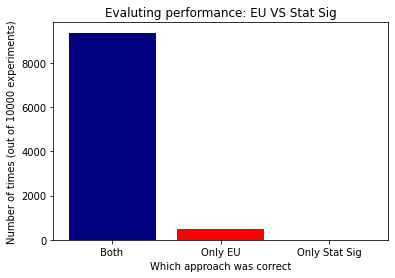

In [34]:
y=[]
for i in countTimesCorrectTuple[1]:
    y.append(i)
x = ["Both", "Only EU", "Only Stat Sig"]
plt.bar(x, y, color=['navy', 'red', 'red'])
plt.title('Evaluting performance: EU VS Stat Sig')        
plt.xlabel("Which approach was correct")
plt.ylabel("Number of times (out of 10000 experiments)")
plt.show()
